In [2]:
#Imports
import pandas as pd
import matplotlib as mpl
from mplsoccer.pitch import VerticalPitch
from matplotlib.colors import to_rgba
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import fig_text
import ipywidgets as widgets
import math

#read csv
df = pd.read_csv('Footballdata/New/ManUtdvsWolves.csv', encoding='latin-1')
df = df.fillna(0)

#Import EPV
epv = pd.read_csv("EPVGrid.csv", header=None)
epv = np.array(epv)
n_rows, n_cols = epv.shape

#Adjust to pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#Combo box, choose team
options = df["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Wolves', 'Manchester United'), placehold…

In [3]:
#Retrieve Team
team = teamlist.value

#Retrieve Opposition team (only use when there's two available teams for selection)
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

#Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60*df["minute"]+df["second"]

df.sort_values(by=['newsecond'])

#find time of the team's first substitution and filter the df to only passes before that
Subs = df.loc[(df['type_displayName']=="SubstitutionOff") & (df['teamId'] == team)]
SubTimes = Subs["newsecond"]
SubOne = SubTimes.min()

#remove substitution events,challenges & formation change
df = df.loc[~(df['type_displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type_displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type_displayName'] == 'FormationChange')]
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~(df['type_displayName'] == 'FormationSet')]
df = df.loc[~(df['type_displayName'] == 'Start')]
df = df.loc[~(df['type_displayName'] == 'End')]

#remove the records of a failed aerial, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#remove the records of a failed aerial, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type_displayName'] == 'Tackle') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#length of passes
df['passlength'] = np.sqrt(np.square(df['endX']-df['x']) + np.square(df['endY']-df['y']))

#find if the next event is by the same team
df['teamId_next'] = df['teamId'].shift(-1)

In [6]:
#Remove warning
pd.options.mode.chained_assignment = None

#filter for only actions by the team you want
OneTeam = df.loc[(df['teamId']== team)]

#identify the passer and then the recipient, who'll be the playerId of the next action
OneTeam['passer'] = OneTeam['shirtNo']
OneTeam['recipient'] = OneTeam['passer'].shift(-1)

#Filter to make sure recipients are from the same team
OneTeam = OneTeam.loc[(OneTeam['teamId_next'] == OneTeam['teamId'])]

#filter for only passes and then successful passes
Passes = OneTeam.loc[(OneTeam['type_displayName']=="Pass")]
Completions_df = Passes.loc[(Passes['outcomeType_displayName']=="Successful")]

#Downcast Kit numbers from float to integer
pas = pd.to_numeric(Completions_df['passer'],downcast='integer')
rec = pd.to_numeric(Completions_df['recipient'],downcast='integer')

#New columns for passer and recipient
Completions_df['passer'] = pas
Completions_df['recipient'] = rec

SubTimes

827     2700.0
1179    4065.0
1181    4079.0
1320    4591.0
1504    5227.0
Name: newsecond, dtype: float64

In [7]:
#Measure EPV
#Bin Data
Completions_df['x1_bin'] = pd.cut(Completions_df['x'], bins=n_cols, labels=False)
Completions_df['x2_bin'] = pd.cut(Completions_df['endX'], bins=n_cols, labels=False)
Completions_df['y1_bin'] = pd.cut(Completions_df['y'], bins=n_rows, labels=False)
Completions_df['y2_bin'] = pd.cut(Completions_df['endY'], bins=n_rows, labels=False)

#Return Bin Values
Completions_df['start_zone_value'] = Completions_df[['x1_bin', 'y1_bin']].apply(lambda x: epv[x[1]][x[0]], axis=1)
Completions_df['end_zone_value'] = Completions_df[['x2_bin', 'y2_bin']].apply(lambda x: epv[x[1]][x[0]], axis=1)

#Calculate Difference
Completions_df['epv'] = Completions_df['end_zone_value'] - Completions_df['start_zone_value']

#Remove Bin Columns
Completions_df = Completions_df[[col for col in Completions_df.columns if 'bin' not in col]]

#Set Completions before first sub is made // Completions is df that is filtered by first sub; Completions_df is not
#Completions = Completions_df.loc[Completions_df['period/displayName'] == 'SecondHalf']
#Completions = Completions.loc[Completions['newsecond'] < 3500]
Completions = Completions_df.loc[Completions_df['newsecond'] < SubOne]

In [11]:
#Passes Completed List
successful_pass_list = Completions_df.groupby(['passer','name']).size().reset_index().rename(columns={0:'Passes Completed'}).sort_values('passer', ascending = True).reset_index()
del successful_pass_list['index']
successful_pass_list.rename(columns = {'passer':'Kit Number'},inplace = True)

#Passes Received List
receiver_list = Completions_df.groupby(['recipient']).size().reset_index().rename(columns={0:'Passes Received'}).sort_values('recipient', ascending = True).reset_index()
del receiver_list['index']
receiver_list.rename(columns = {'recipient':'Kit Number'},inplace = True)

#Merge the two lists
Pass_Receive_List = pd.merge(successful_pass_list, receiver_list, on="Kit Number")
Pass_Receive_List = Pass_Receive_List.sort_values('Kit Number', ascending= True).reset_index(drop = True)
Pass_Receive_List.rename(columns = {'name':'Player'},inplace = True)
Pass_Receive_List.index += 1

#PlayerList
Player_list = Pass_Receive_List.drop(labels=['Passes Completed','Passes Received'], axis=1).set_index('Kit Number')

#Pass_Receive_List.median()
Pass_Receive_List

,Kit Number,Player,Passes Completed,Passes Received
1,2,Victor Lindelöf,11,11
2,6,Lisandro Martínez,36,32
3,7,Mason Mount,16,18
4,8,Bruno Fernandes,36,38
5,10,Marcus Rashford,13,26
6,14,Christian Eriksen,8,10
7,18,Casemiro,51,53
8,19,Raphaël Varane,34,29
9,21,Antony,24,27
10,23,Luke Shaw,55,42


In [12]:
#Obtaining passing combinations (for full game, so use Completions_df because it includes full game)
pass_combo = Completions_df.groupby(['passer', 'recipient']).id.count().reset_index()
pass_combo.columns = ['Passer', 'Recipient', 'Passing Combinations']
pass_combo = pass_combo.sort_values(by=['Passing Combinations'] , ascending=False)

#Get top 10 passing combination
top_10_pass_combo = pass_combo.head(9).reset_index(drop=True)
top_10_pass_combo.index += 1
top_10_pass_combo['Recipient'] = top_10_pass_combo['Recipient'].astype(int)
top_10_pass_combo

#Merge for Passer
merge = pd.merge(left=top_10_pass_combo, right=Player_list, how='left',left_on='Passer',right_on='Kit Number')
del merge['Passer']

#Merge for Recipient
merge = pd.merge(left=merge, right=Player_list, how='left',left_on='Recipient',right_on='Kit Number')
del merge['Recipient']

#Renaming and reordering
merge.rename(columns = {'Player_x':'Passer','Player_y':'Recipient'},inplace = True)
merge = merge.reindex(['Passer','Recipient','Passing Combinations'], axis=1)
merge.index += 1
merge

,Passer,Recipient,Passing Combinations
1,Aaron Wan-Bissaka,Casemiro,14
2,Raphaël Varane,Aaron Wan-Bissaka,10
3,Casemiro,Antony,9
4,Aaron Wan-Bissaka,Raphaël Varane,9
5,Alejandro Garnacho,Luke Shaw,8
6,André Onana,Aaron Wan-Bissaka,8
7,Luke Shaw,Casemiro,8
8,Luke Shaw,Lisandro Martínez,8
9,Lisandro Martínez,Luke Shaw,8


In [13]:
#For specific player (Passer)
player_pass_combo = pass_combo.loc[(pass_combo['Passer'] == 1)].reset_index(drop=True)
player_pass_combo.index += 1
player_pass_combo['Recipient'] = player_pass_combo['Recipient'].astype(int)
player_pass_combo

#Merge for Passer
merge = pd.merge(left=player_pass_combo, right=Player_list, how='left',left_on='Passer',right_on='Kit Number')
del merge['Passer']

#Merge for Recipient
merge = pd.merge(left=merge, right=Player_list, how='left',left_on='Recipient',right_on='Kit Number')
del merge['Recipient']

#Renaming and reordering
merge.rename(columns = {'Player_x':'Passer','Player_y':'Recipient'},inplace = True)
merge = merge.reindex(['Passer','Recipient','Passing Combinations'], axis=1)
merge.index += 1
merge.head(10)

,Passer,Recipient,Passing Combinations


In [19]:
#For specific player (Receiver)
player_receive_combo = pass_combo.loc[(pass_combo['Recipient'] == 17)].reset_index(drop=True)
player_receive_combo.index += 1
player_receive_combo['Recipient'] = player_receive_combo['Recipient'].astype(int)
player_receive_combo

#Merge for Passer
merge = pd.merge(left=player_receive_combo, right=Player_list, how='left',left_on='Passer',right_on='Kit Number')
del merge['Passer']

#Merge for Recipient
merge = pd.merge(left=merge, right=Player_list, how='left',left_on='Recipient',right_on='Kit Number')
del merge['Recipient']

#Renaming and reordering
merge.rename(columns = {'Player_x':'Passer','Player_y':'Recipient'},inplace = True)
merge = merge.reindex(['Passer','Recipient','Passing Combinations'], axis=1)
merge.index += 1
merge.head(10)

,Passer,Recipient,Passing Combinations


In [20]:
#Calculate EPV for full game
EPV = Completions_df.groupby('name').agg({'epv': ['sum']})
EPV.columns = ['EPV']
EPV = EPV.sort_values('EPV', ascending= False)
EPV

,EPV
name,
Bruno Fernandes,0.7452
Aaron Wan-Bissaka,0.5981
Casemiro,0.1972
Luke Shaw,0.1117
Lisandro Martínez,0.0775
Jadon Sancho,0.0518
Antony,0.0333
Alejandro Garnacho,0.0257
Marcus Rashford,0.0208


In [21]:
#Find Average Locations with Completions, EPV is filtered till first sub
average_locs_and_count = Completions.groupby('passer').agg({'x': ['median'], 'y': ['median','count'],'epv':['sum']})
average_locs_and_count.columns = ['x', 'y', 'count','EPV']
average_locs_and_count

size = 60

#Size of the node later on, dependent on the passes made
player_pass_count = Completions.groupby("passer").size().to_frame("num_passes")
player_pass_count['num_passes'] = player_pass_count['num_passes'] * size

#Find out the passes made till first sub is made
player_pass_count1 = player_pass_count / size
#average_locs_and_count = average_locs_and_count.drop(17)
average_locs_and_count

,x,y,count,EPV
passer,,,,
6,44.28,56.64,35,0.0748
7,65.76,48.00,11,-0.0077
8,64.92,37.04,17,0.0681
10,82.68,46.80,7,0.0228
18,57.60,33.52,35,0.0852
19,49.02,27.28,24,0.0051
21,88.20,20.40,15,0.0105
23,51.48,61.52,32,0.0399
24,14.64,38.48,21,-0.0076


In [22]:
#find number of passes along each 'path' of passer to recipient
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True,
                                      suffixes=['', '_end'])

#set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
number = 3
passes_between_df = passes_between.loc[(passes_between['pass_count']>number)]
number=str(number)

#Line width
line = passes_between_df.pass_count / passes_between_df.pass_count.max()
#passes_between_df

# Tableau Sized Chart

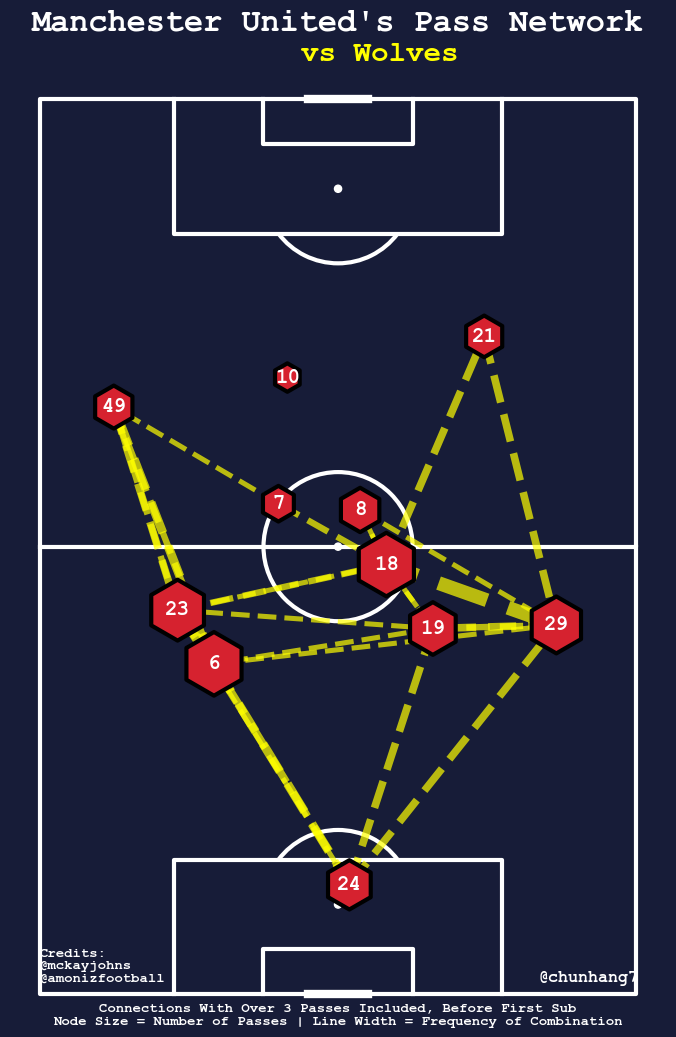

In [23]:
#plot pitch
pitch = VerticalPitch(line_color='w', line_zorder=1, pitch_color='#171c38',
                     spot_scale=0.004, linewidth=3)

fig, ax = pitch.draw(figsize=(15,10.5))

#Inverse x-axis
plt.gca().invert_xaxis()

pitch.lines(passes_between_df.x, passes_between_df.y, passes_between_df.x_end,passes_between_df.y_end, 
            linewidth=line*10, color='yellow', ax=ax, zorder = 3, alpha = .7,ls='--')

#plot nodes
pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y, s=player_pass_count, marker='h',
                           color='#d6222f', edgecolors="black", linewidth=3, alpha=1, ax=ax, zorder=3)

#Kit Numbers on Nodes
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x,row.y), c='w', va='center', ha='center', 
                   size=15, fontweight='bold', fontfamily="Courier New",ax=ax)

#Set the background color
fig.patch.set_facecolor('#171c38') #005f60

#annotations
ax.set_title(team + "'s Pass Network\n", fontsize=23, color="w", fontfamily="Courier New", fontweight='bold', pad=-10)

fig.text(.58,.937,"vs "+oppo,fontsize=21,fontfamily='Courier New',ha='right',color='yellow',fontweight='bold')

#credits
fig.text(.7,.06,'@chunhang7',fontsize=12,fontfamily='Courier New', ha='right',color='w',fontweight='bold')

fig.text(.301,.06,'Credits:\n@mckayjohns\n@amonizfootball',fontsize=10,fontfamily='Courier New', ha='left',
         color='w',fontweight='bold')

#annotations/key at bottom
pitch.annotate("\nConnections With Over " + number + " Passes Included, Before First Sub\nNode Size = Number of Passes | Line Width = Frequency of Combination", 
               (-2, 40), color='w',
               fontsize=10, ha='center', va='center', ax=ax, fontweight='bold', fontfamily="Courier New")
plt.show()

# Vertical Pitch

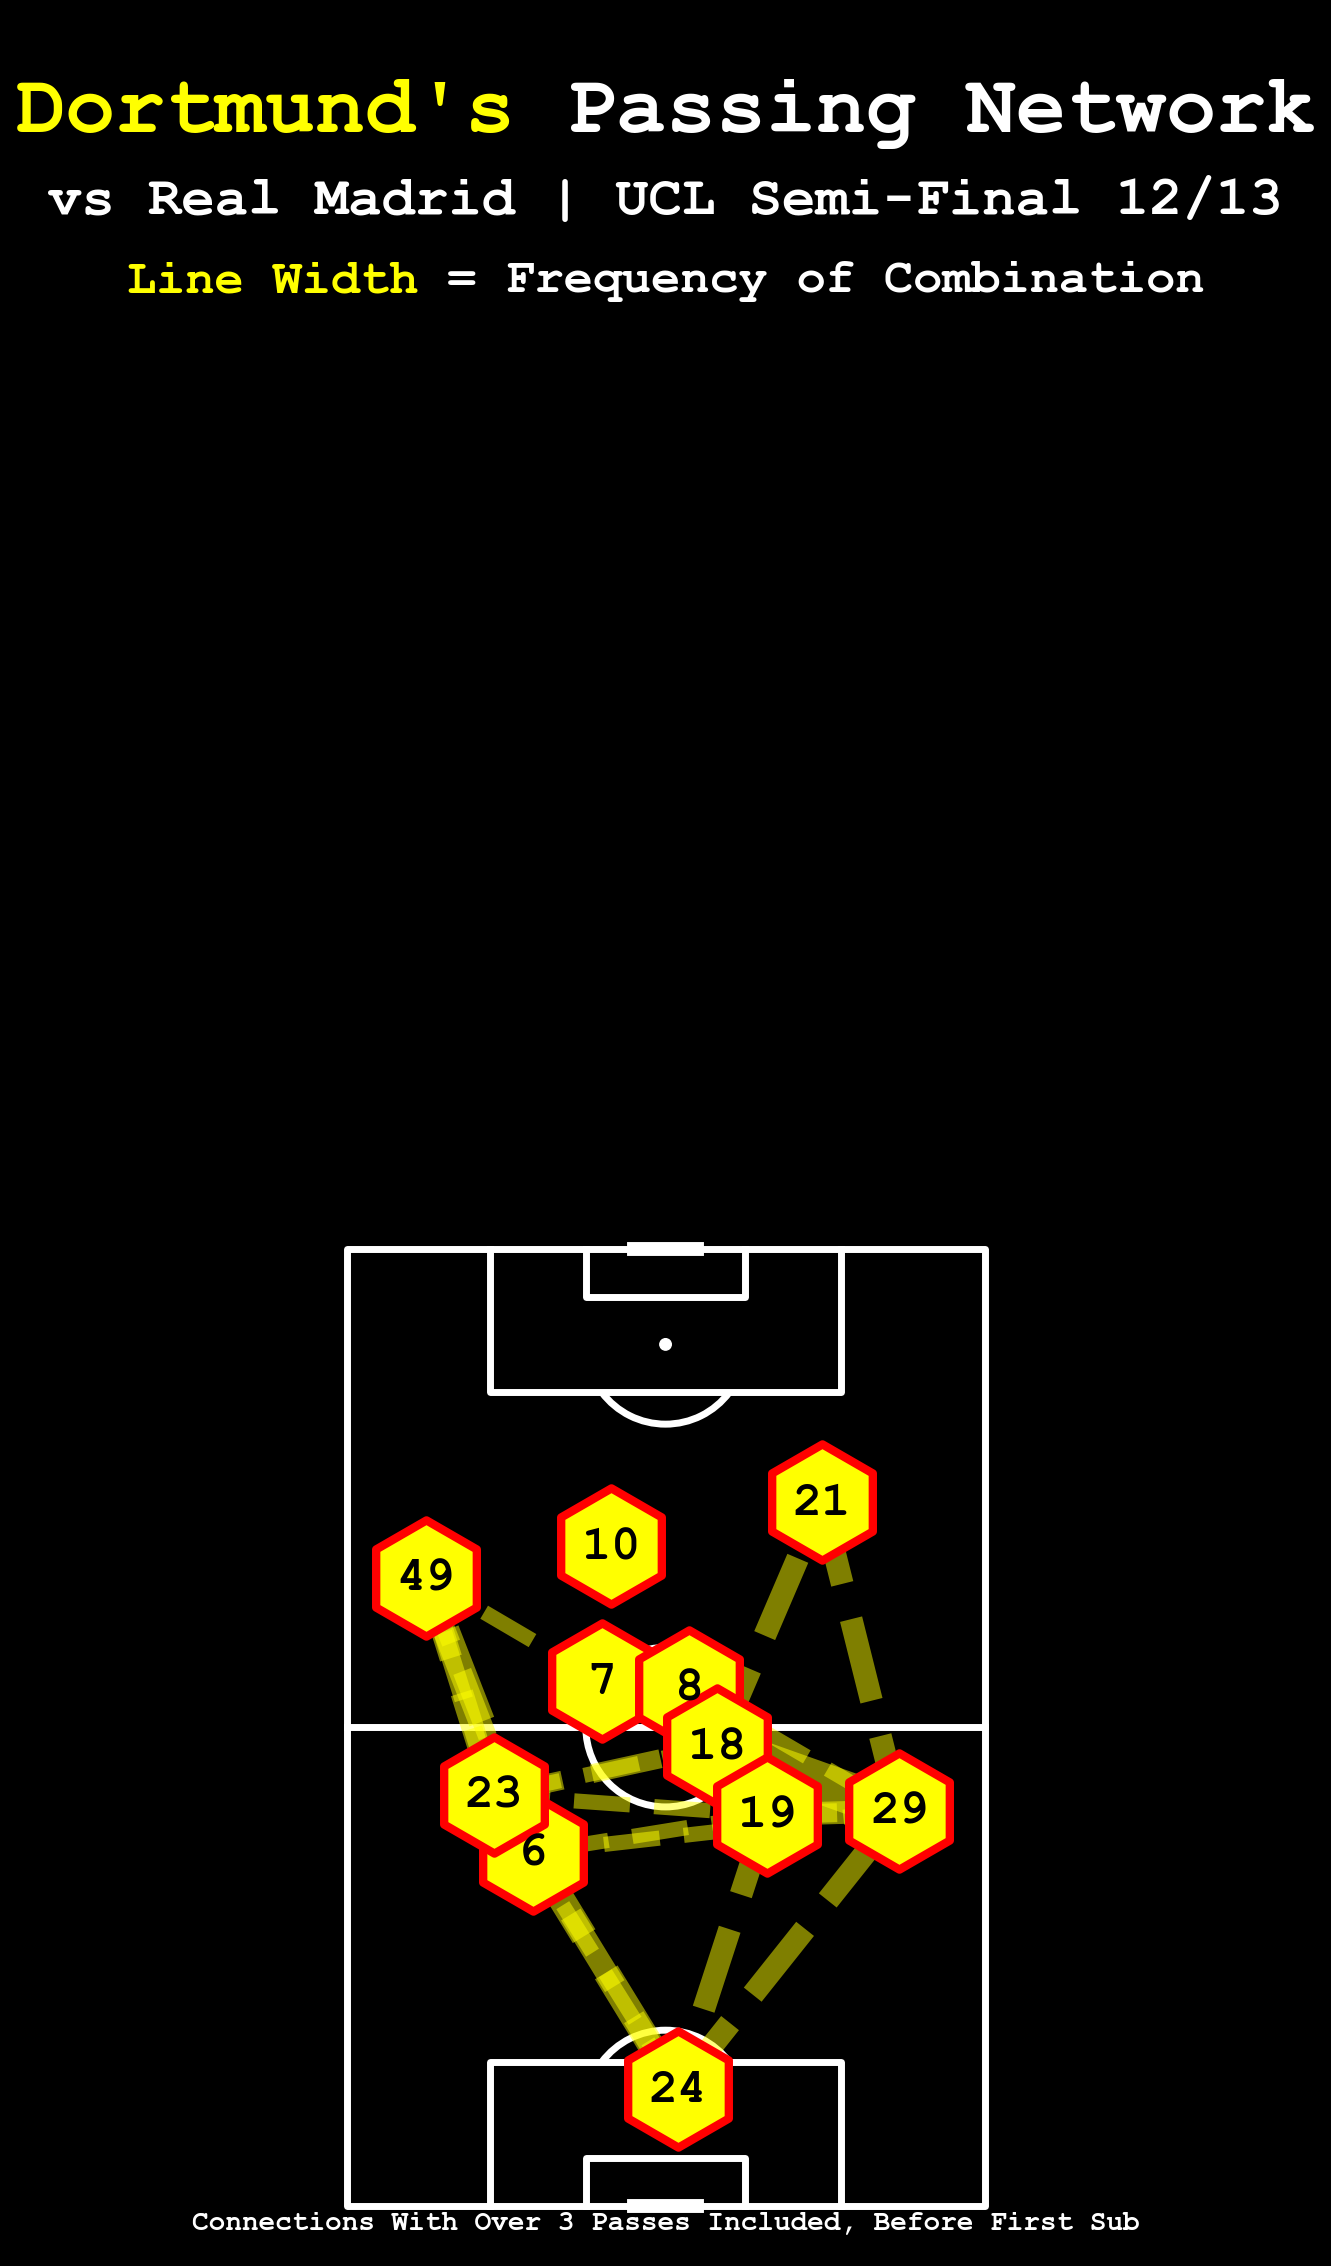

In [24]:
#Set up pitch
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='white',
                      half = False, line_zorder=1, linewidth=5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

pitch.lines(passes_between_df.x, passes_between_df.y, passes_between_df.x_end,passes_between_df.y_end, 
            linewidth=line*30, color='yellow', ax=ax, zorder = 3, alpha = .5,ls='--')

#plot nodes
pass_nodes = pitch.scatter(average_locs_and_count.x, average_locs_and_count.y, s=7000, marker='h',
                           color='yellow', edgecolors='red', linewidth=6, alpha=1, ax=ax, zorder=3)

#Kit Numbers on Nodes
for index, row in average_locs_and_count.iterrows():
    pitch.annotate(row.name, xy=(row.x-0.25,row.y), c='black', va='center', ha='center', 
                   size=35, fontweight='bold', fontfamily="Courier New",ax=ax)

#Title
highlight_textprops =\
    [{"color": "yellow","fontweight": 'bold'}]

fig_text(s = "\n<Dortmund's> Passing Network",
        x = 0.5, y = 1.08, highlight_textprops = highlight_textprops ,color='w',
        fontfamily = "Courier New",fontweight='bold', ha='center',va='center',fontsize=60)

highlight_textprops =\
    [{"color": "w","fontweight": 'bold'}]

fig_text(s = "vs <Real Madrid> | UCL Semi-Final 12/13",
        x = 0.5, y = 1.035, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',va='center',fontsize=40)

highlight_textprops =\
    [{"color": "yellow","fontweight": 'bold'}]

fig_text(s = "<Line Width> = Frequency of Combination" ,
        x = 0.5, y = 1.005, highlight_textprops = highlight_textprops ,color='white',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=35)

#annotations/key at bottom
pitch.annotate("Connections With Over " + number + " Passes Included, Before First Sub", 
               (-2.25, 40), color='w', fontsize=20, ha='center', va='center', ax=ax, fontweight='bold', fontfamily="Courier New")

#Space
ax.text(95, -4.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(-8, -4.5, 'space', va='center', ha='left', fontsize=25, color='black',
        fontweight = "bold",fontfamily = "Courier New")

fig_text(s = "Space",x = 0.5, y = 1.125 ,color='black',
         fontfamily = "Courier New",fontweight='bold',
         ha='center',va='center',fontsize=10)

"""
fig.text(0.58,0.51,'Alexander-Arnold',fontsize=25, fontfamily='Courier New',
         ha='center',color='red',fontweight='bold')


#credits
fig.text(.7,.06,'@chunhang7\nData via Opta',fontsize=20, fontfamily='Courier New', 
         ha='right',color='w',fontweight='bold')

fig.text(.301,.06,'Credits:\n@mckayjohns\n@amonizfootball', fontsize=20,
         fontfamily='Courier New', ha='left', color='w',fontweight='bold')
"""
plt.show()